#  spectra at AuxTel for Planetary Nebula

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- creation date : September 22th  2021



- **kernel anaconda3_auxtel**

# Imports

In [68]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd

plt.rcParams["figure.figsize"] = (16,4)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

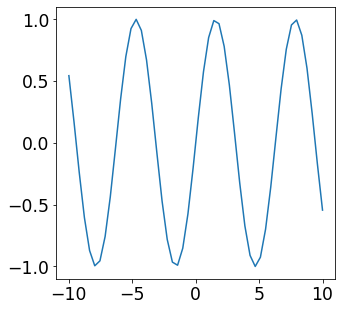

In [69]:
fig=plt.figure(figsize=(5,5))
ax=fig.add_subplot(1,1,1)
X=np.linspace(-10,10,50)
Y=np.sin(X)
ax.plot(X,Y)
plt.show()               

In [70]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [71]:
from datetime import datetime,date

In [72]:
today = date.today()
string_date=today.strftime("%Y-%m-%d")

In [73]:
string_date

'2021-09-23'

In [74]:
from iminuit import Minuit
import iminuit

In [75]:
iminuit.__version__

'2.2.0'

In [76]:
from astropy.io import fits
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor
from spectractor.extractor.spectrum import Spectrum, detect_lines
from spectractor.extractor.spectrum import *
#from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, O2_1, H2O_1,H2O_2
from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, O2_1, H2O_1
from spectractor.config import load_config
from spectractor import parameters
from spectractor.extractor.images import *
from scipy import ndimage, misc
from scipy.interpolate import interp1d

In [77]:
H2O_2 = Line(960, atmospheric=True, label=r'$H_2 O$', label_pos=[0.007, 0.02],width_bounds=[5, 30])  # libradtran paper fig.3, broad line

In [78]:
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

In [79]:
from time import sleep

In [80]:
from astropy.time import Time
import astropy.units as u

# Function

In [81]:
def file_target(filename):
    m=re.findall('^holo4_003_.*_(.*)_[0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*_quickLoopExp[.]fits$',filename)
    if len(m)>0:
        return m
    elif re.search('NGC4755',filename):
        return ['NGC4755']
    else:
        return []

# Path

In [82]:
path_auxtel="/sps/lsst/groups/auxtel"
path_spectractor=os.path.join(path_auxtel,"softs/github/desc/Spectractor")
path_spectractor_config=os.path.join(path_spectractor,"config")
path_images=os.path.join(path_auxtel,"data/2021/holo/quickLookExp/2021-09-09")

In [83]:
#config = os.path.join(path_spectractor_config,"auxtel_quicklook.ini")

# standard configuration
# config = os.path.join(path_spectractor_config,"auxtel.ini")
# special for scan in XY (dispersion rotation angle)
config="./config/auxtel_scanXY.ini"

# Logbook for file selection

In [84]:
! ls logbooks

auxtelholologbook_2021_07_06_v2.0.csv
auxtelholologbook_2021_07_06_v2.0.xlsx
auxtelholologbook_2021_07_07_v3.0.csv
auxtelholologbook_2021_07_07_v3.0.xlsx
auxtelholologbook_PNG_2021_09_09_v2.0.csv
auxtelholologbook_PNG_2021_09_09_v2.0.xlsx


In [85]:
filename_logbook='logbooks/auxtelholologbook_PNG_2021_09_09_v2.0.csv'

In [86]:
df=pd.read_csv(filename_logbook,index_col=0)

In [87]:
pd.set_option('display.max_rows', None)

In [88]:
df

,index,date,path,file,num,object,filter,disperser,airmass,exposure,...,temperature,humidity,windspd,Obj-posXpix,Obj-posYpix,Dx,Dy,skip,run,quality
0,0,2021-09-09T23:53:55.100,/sps/lsst/groups/auxtel/data/2021/holo/quickLo...,holo4_003_empty_PNG321.0+03.9_20210909_000165_...,165,PNG321.0+03.9,empty_1,holo4_003,1.380357,10.0,...,9.2,16.0,4.0,300.0,1750.0,NaN,NaN,,1.0,1.0
1,1,2021-09-09T23:54:18.095,/sps/lsst/groups/auxtel/data/2021/holo/quickLo...,holo4_003_empty_PNG321.0+03.9_20210909_000166_...,166,PNG321.0+03.9,empty_1,holo4_003,1.381613,10.0,...,9.1,16.0,3.6,300.0,1750.0,NaN,NaN,,1.0,1.0
2,2,2021-09-09T23:54:41.122,/sps/lsst/groups/auxtel/data/2021/holo/quickLo...,holo4_003_empty_PNG321.0+03.9_20210909_000167_...,167,PNG321.0+03.9,empty_1,holo4_003,1.382874,10.0,...,9.1,16.0,3.6,300.0,1750.0,NaN,NaN,,1.0,1.0
3,3,2021-09-09T23:55:04.180,/sps/lsst/groups/auxtel/data/2021/holo/quickLo...,holo4_003_empty_PNG321.0+03.9_20210909_000168_...,168,PNG321.0+03.9,empty_1,holo4_003,1.384148,30.0,...,9.1,16.0,3.6,300.0,1750.0,NaN,NaN,,1.0,1.0
4,4,2021-09-09T23:55:47.196,/sps/lsst/groups/auxtel/data/2021/holo/quickLo...,holo4_003_empty_PNG321.0+03.9_20210909_000169_...,169,PNG321.0+03.9,empty_1,holo4_003,1.386523,30.0,...,9.0,17.0,3.1,300.0,1750.0,NaN,NaN,,1.0,1.0
5,5,2021-09-09T23:56:30.224,/sps/lsst/groups/auxtel/data/2021/holo/quickLo...,holo4_003_empty_PNG321.0+03.9_20210909_000170_...,170,PNG321.0+03.9,empty_1,holo4_003,1.388908,30.0,...,9.0,16.0,3.9,300.0,1750.0,NaN,NaN,,1.0,1.0
6,6,2021-09-09T23:57:13.142,/sps/lsst/groups/auxtel/data/2021/holo/quickLo...,holo4_003_empty_PNG321.0+03.9_20210909_000171_...,171,PNG321.0+03.9,empty_1,holo4_003,1.391300,60.0,...,9.0,16.0,3.9,300.0,1750.0,NaN,NaN,,1.0,1.0
7,7,2021-09-10T00:04:18.230,/sps/lsst/groups/auxtel/data/2021/holo/quickLo...,holo4_003_empty_PNG321.0+03.9_20210909_000174_...,174,PNG321.0+03.9,empty_1,holo4_003,1.415803,0.0,...,8.9,15.0,3.7,300.0,1750.0,NaN,NaN,,1.0,1.0
8,8,2021-09-10T00:06:01.239,/sps/lsst/groups/auxtel/data/2021/holo/quickLo...,holo4_003_empty_PNG321.0+03.9_20210909_000175_...,175,PNG321.0+03.9,empty_1,holo4_003,1.421962,60.0,...,8.9,15.0,3.8,300.0,1750.0,NaN,NaN,,1.0,1.0
9,9,2021-09-10T00:07:14.156,/sps/lsst/groups/auxtel/data/2021/holo/quickLo...,holo4_003_empty_PNG321.0+03.9_20210909_000176_...,176,PNG321.0+03.9,empty_1,holo4_003,1.426365,60.0,...,8.9,15.0,4.4,300.0,1750.0,NaN,NaN,,1.0,1.0


# Selection of input file

In [89]:
df_good=df[df["quality"]==1]

In [90]:
for spectra_file in df_good["file"]:
    print(spectra_file)

holo4_003_empty_PNG321.0+03.9_20210909_000165_quickLookExp.fits
holo4_003_empty_PNG321.0+03.9_20210909_000166_quickLookExp.fits
holo4_003_empty_PNG321.0+03.9_20210909_000167_quickLookExp.fits
holo4_003_empty_PNG321.0+03.9_20210909_000168_quickLookExp.fits
holo4_003_empty_PNG321.0+03.9_20210909_000169_quickLookExp.fits
holo4_003_empty_PNG321.0+03.9_20210909_000170_quickLookExp.fits
holo4_003_empty_PNG321.0+03.9_20210909_000171_quickLookExp.fits
holo4_003_empty_PNG321.0+03.9_20210909_000174_quickLookExp.fits
holo4_003_empty_PNG321.0+03.9_20210909_000175_quickLookExp.fits
holo4_003_empty_PNG321.0+03.9_20210909_000176_quickLookExp.fits
holo4_003_empty_PNG321.0+03.9_20210909_000177_quickLookExp.fits


In [91]:
#dir_spectra="outputs_reprocess"
dir_spectra="outputs_process_holo_PNG"

In [92]:
! ls $dir_spectra

holo4_003_empty_PNG321.0+03.9_20210909_000177_quickLookExp_lines.csv
holo4_003_empty_PNG321.0+03.9_20210909_000177_quickLookExp_spectrogram.fits
holo4_003_empty_PNG321.0+03.9_20210909_000177_quickLookExp_spectrum.fits
holo4_003_empty_PNG321.0+03.9_20210909_000177_quickLookExp_table.csv


In [93]:
all_files=os.listdir(dir_spectra)

In [94]:
all_spectra_files = []
for filename in all_files:
    if re.search("_spectrum.fits$",filename):
        all_spectra_files.append(filename)
N=len(all_spectra_files)

In [95]:
all_spectra_files

['holo4_003_empty_PNG321.0+03.9_20210909_000177_quickLookExp_spectrum.fits']

In [96]:
df_good["file"].values

array(['holo4_003_empty_PNG321.0+03.9_20210909_000165_quickLookExp.fits',
       'holo4_003_empty_PNG321.0+03.9_20210909_000166_quickLookExp.fits',
       'holo4_003_empty_PNG321.0+03.9_20210909_000167_quickLookExp.fits',
       'holo4_003_empty_PNG321.0+03.9_20210909_000168_quickLookExp.fits',
       'holo4_003_empty_PNG321.0+03.9_20210909_000169_quickLookExp.fits',
       'holo4_003_empty_PNG321.0+03.9_20210909_000170_quickLookExp.fits',
       'holo4_003_empty_PNG321.0+03.9_20210909_000171_quickLookExp.fits',
       'holo4_003_empty_PNG321.0+03.9_20210909_000174_quickLookExp.fits',
       'holo4_003_empty_PNG321.0+03.9_20210909_000175_quickLookExp.fits',
       'holo4_003_empty_PNG321.0+03.9_20210909_000176_quickLookExp.fits',
       'holo4_003_empty_PNG321.0+03.9_20210909_000177_quickLookExp.fits'],
      dtype=object)

In [97]:
all_good_spectra_spectrum_files=[]

idx=0
for good_spectra_file in df_good["file"].values:
    good_spectra_spectrum_file = good_spectra_file.split(".fits")[0]+"_spectrum.fits"
    if good_spectra_spectrum_file in all_spectra_files:
        print(idx,") : found {}".format(good_spectra_spectrum_file))
        all_good_spectra_spectrum_files.append(good_spectra_spectrum_file)
        idx+=1

0 ) : found holo4_003_empty_PNG321.0+03.9_20210909_000177_quickLookExp_spectrum.fits


In [98]:
all_good_spectra_spectrum_files

['holo4_003_empty_PNG321.0+03.9_20210909_000177_quickLookExp_spectrum.fits']

0 ) holo4_003_empty_PNG321.0+03.9_20210909_000177_quickLookExp_spectrum.fits   outputs_process_holo_PNG/holo4_003_empty_PNG321.0+03.9_20210909_000177_quickLookExp_spectrum.fits


2021-09-23 11:33:59  astropy    _showwarning         WARNING ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
2021-09-23 11:33:59  astropy    _showwarning         WARNING ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"


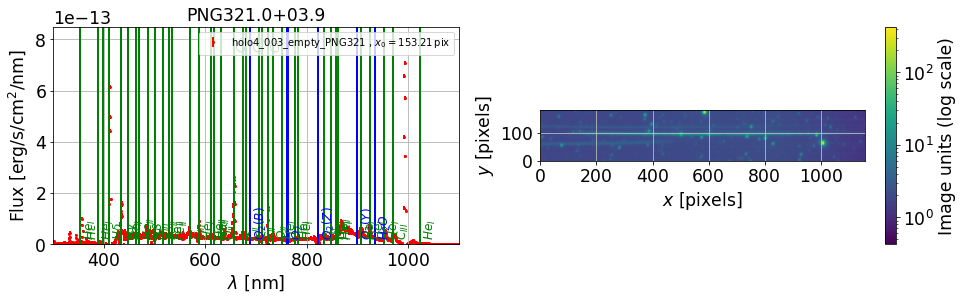

In [99]:
parameters.DISPLAY=False

infos = []

idx=0
for filename in all_good_spectra_spectrum_files:
    fig=plt.figure(figsize=(16,4))
    ax1 = fig.add_subplot(1, 2, 1)
    
    fullfilename = os.path.join(dir_spectra,filename)
    
    print(idx,")",filename," ",fullfilename)
    
    
    #try:
    #    s=Spectrum(fullfilename, config="config/auxtel_quicklook.ini")
    #    print("Success First Connection with file "+ fullfilename)
    #    break           
    #except requests.exceptions.ConnectionError:
    #except:
    #    print("Connection refused, will retry")
    #    sleep(5)
    #    try:
    #        print("try connection again ")    
    #        s=Spectrum(fullfilename, config="config/auxtel_quicklook.ini")
    #        print("Success Second Connection ")
    #        break
        
        #except requests.exceptions.ConnectionError:
    #    except:
    #        print("Connection refused twice, give up")
    #        continue
            
    #    continue
                   
    
    s=Spectrum(fullfilename, config=config)
    label=filename.split('.')[0]+" "
    s.plot_spectrum(ax=ax1,force_lines=True,label=label)
    
    ax2 = fig.add_subplot(1, 2, 2)
    
    fullfilename2=fullfilename.replace("_spectrum","_spectrogram")
    
    s.load_spectrogram(fullfilename2)
    s.plot_spectrogram(ax=ax2,scale="log")
    
    
    infos.append([idx,s.date_obs,s.airmass,s.temperature,s.pressure,s.humidity])
    
    
    plt.show()
    idx+=1
    

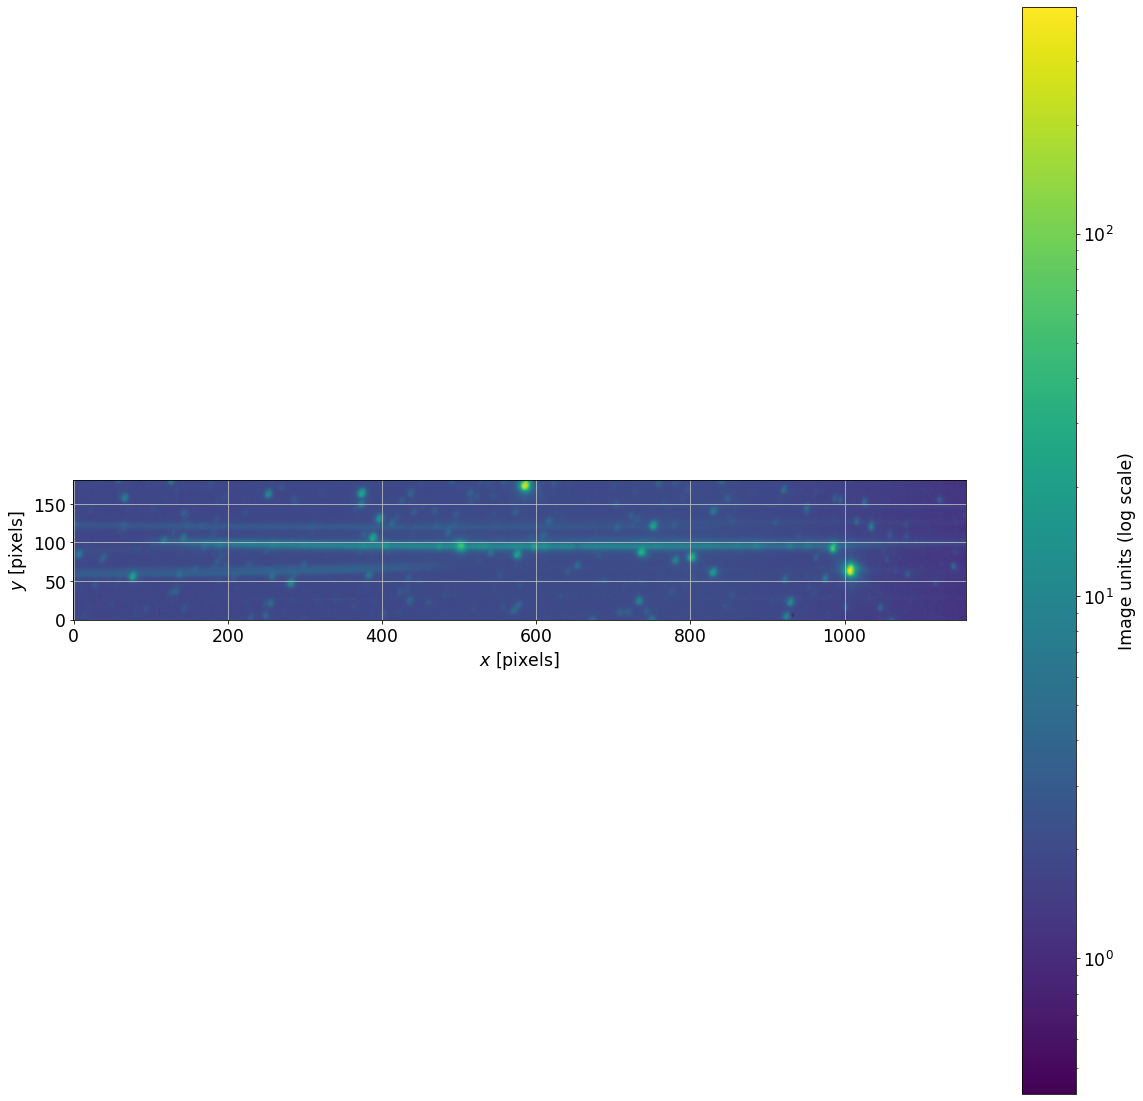

In [100]:
fig=plt.figure(figsize=(20,20))
ax=fig.add_subplot(1,1,1)
s.plot_spectrogram(ax=ax,scale="log")

In [101]:
s.lambdas

array([ 301.17370117,  301.88435928,  302.59500664, ..., 1108.37349103,
       1109.05521703, 1109.73690464])

In [102]:
s.data


array([ 1.33055860e-14, -9.40592828e-15,  4.42794707e-15, ...,
       -4.45541328e-16, -6.66797523e-16, -1.02946105e-15])

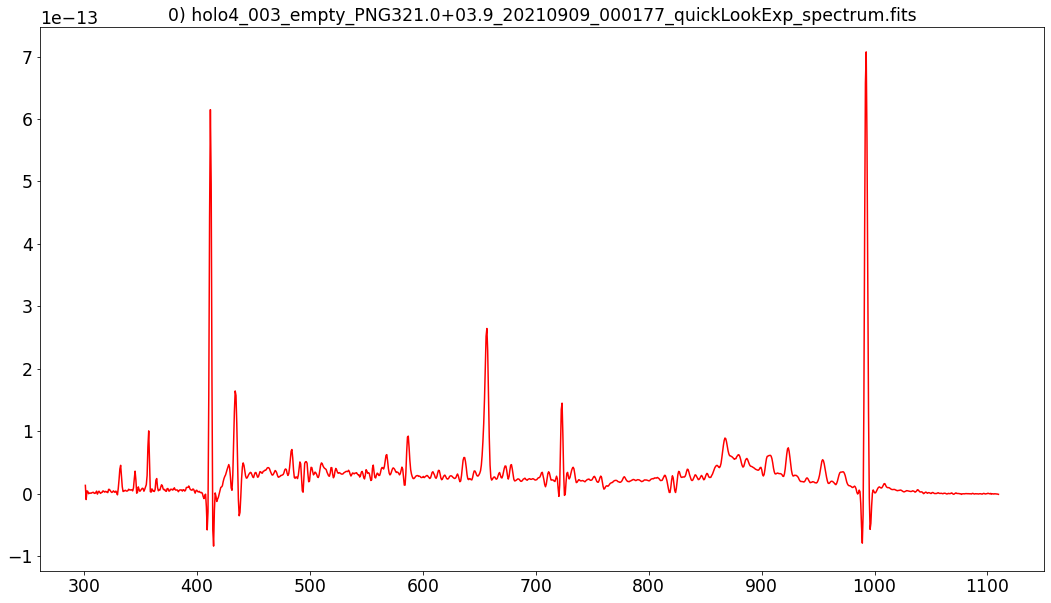

In [103]:
fig = plt.figure(figsize=(18,10))
plt.plot(s.lambdas,s.data,"r-")
thetitle=str(IDXSEL)+") "+ filename_SEL
plt.title(thetitle)
ax.grid()
plt.show()


In [104]:
df_infos=pd.DataFrame(infos,columns=["idx","date_obs","airmass","temperature","pressure","humidity"])

In [105]:
df_infos.set_index('idx',inplace=True)

In [106]:
all_reftime=[ (Time(tt)-Time( df_infos["date_obs"].values[0])).to_value(u.hr) for tt in df_infos["date_obs"].values ]

In [107]:
all_reftime=np.array(all_reftime)

In [108]:
df_infos["reftime"]=all_reftime

In [109]:
df_infos["eqw_h2o"] = np.nan
df_infos["eqw_o2"] = np.nan
df_infos["eqw_o2_spec"] = np.nan

In [110]:
df_infos

,date_obs,airmass,temperature,pressure,humidity,reftime,eqw_h2o,eqw_o2,eqw_o2_spec
idx,,,,,,,,,
0,2021-09-10T00:08:53.255,1.432777,8.9,742.1,15.0,0.0,NaN,NaN,NaN


# Selection of spectra and equivalent width calculation

In [111]:
from astropy import units as u
from astropy.visualization import quantity_support

quantity_support()  # for getting units on the axes below  

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x7f068f409550>

In [112]:
from specutils import Spectrum1D
from specutils.fitting import fit_generic_continuum,fit_continuum
from specutils import SpectralRegion
from specutils.analysis import equivalent_width
from astropy.modeling import models
from specutils.manipulation import extract_region

In [113]:
IDXSEL=0
filename_SEL=all_good_spectra_spectrum_files[IDXSEL]
filename_spectrogram_SEL=filename_SEL.replace("_spectrum","_spectrogram")
filename_lines_SEL=filename_SEL.replace("_spectrum.fits","_lines.csv")
filename_table_SEL=filename_SEL.replace("_spectrum.fits","_table.csv")
fullfilename_SEL = os.path.join(dir_spectra,filename_SEL)
fullfilename_spectrogram_SEL = fullfilename_SEL.replace("_spectrum","_spectrogram")
fullfilename_lines_SEL = fullfilename_SEL.replace("_spectrum.fits","_lines.csv")
fullfilename_table_SEL = fullfilename_SEL.replace("_spectrum.fits","_table.csv")

In [114]:
fullfilename_table_SEL

'outputs_process_holo_PNG/holo4_003_empty_PNG321.0+03.9_20210909_000177_quickLookExp_table.csv'

In [115]:
thetitle=str(IDXSEL)+") "+filename_SEL

In [116]:
thetitle

'0) holo4_003_empty_PNG321.0+03.9_20210909_000177_quickLookExp_spectrum.fits'

In [117]:
fullfilename_SEL

'outputs_process_holo_PNG/holo4_003_empty_PNG321.0+03.9_20210909_000177_quickLookExp_spectrum.fits'

## Load spectrum and Spectrogram

In [118]:
s=Spectrum(fullfilename_SEL, config=config)
s.load_spectrogram(fullfilename_spectrogram_SEL) 

2021-09-23 11:34:06  astropy    _showwarning         WARNING ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
2021-09-23 11:34:06  astropy    _showwarning         WARNING ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"


In [119]:
df_lines=pd.read_csv(fullfilename_lines_SEL,index_col=0)

In [120]:
df_lines

,Tabulated,Detected,Shift,FWHM,Amplitude,SNR,Chisq,Eqwidth_mod,Eqwidth_data
Line,,,,,,,,,
$He_{I}$,353.100006,357.033051,3.933042,2.711429,4.517800e-14,6.093473,7.302995,-15.526402,-16.976120
$H\delta$,410.200012,411.836334,1.636330,2.374248,5.158638e-13,69.578163,7.302995,285.038635,257.259064
$H\gamma$,434.000000,432.864380,-1.135609,9.571228,8.961639e-14,12.087190,7.302995,87.158775,188.575562
$He_{I}$,447.100006,446.322205,-0.777799,9.609943,4.194215e-14,5.657032,7.302995,31.808180,165.707596
$Fe_{II}$,463.799988,457.343262,-6.456725,13.569626,4.024632e-14,5.428303,7.302995,38.783997,218.714478
$He_{II}$,468.600006,468.424866,-0.175147,13.948812,4.222565e-14,5.695269,7.302995,40.416607,204.532913
$H\beta$,486.299988,483.092621,-3.207368,13.025314,5.865225e-14,7.910841,7.302995,57.455269,225.930695
$O_{III}$,500.700012,498.026764,-2.673238,12.790529,4.530732e-14,6.110915,7.302995,65.166611,128.298325
$Fe_{II}$,515.799988,511.108093,-4.691904,11.082700,4.169438e-14,5.623613,7.302995,74.255875,37.847282


In [121]:
lines = Lines([O2_1,H2O_1,H2O_2],atmospheric_lines=True, redshift=0, emission_spectrum=False)

In [122]:
s.lines = lines

In [123]:
lambdas = np.arange(300,1000,1)
fwhm_func = interp1d(lambdas, 0.01 * lambdas)

In [124]:
# global_chisq = detect_lines(lines, s.lambdas, s.data, s.err, fwhm_func=fwhm_func)

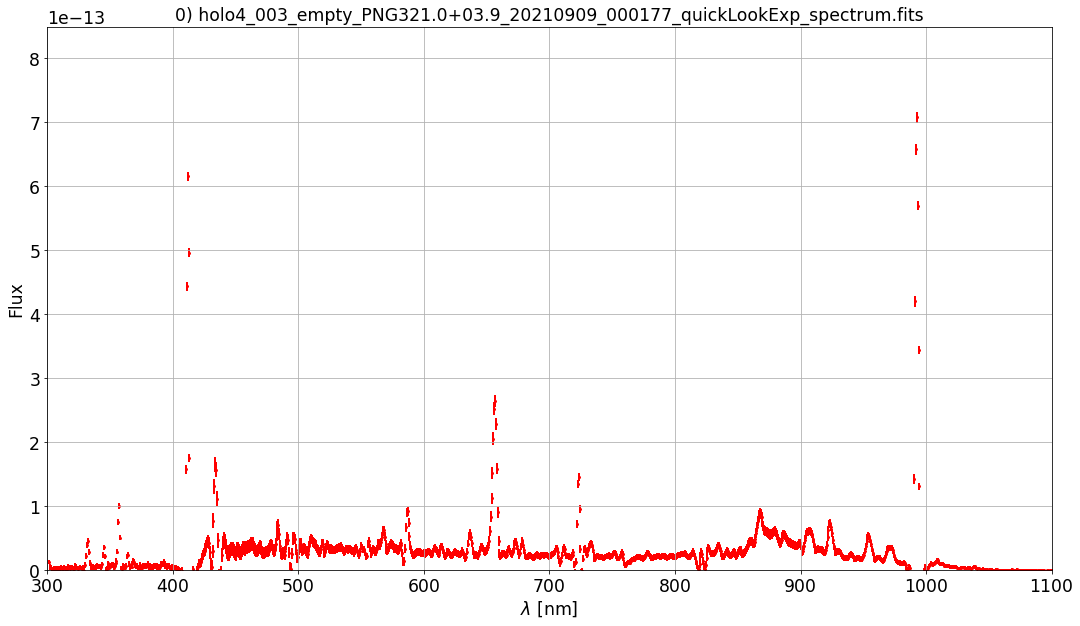

In [125]:
fig = plt.figure(figsize=(18,10))
plot_spectrum_simple(plt.gca(), s.lambdas, s.data, s.err)
lines.plot_detected_lines(plt.gca())
thetitle=str(IDXSEL)+") "+ filename_SEL
plt.title(thetitle)
plt.show()

In [126]:
# lines.print_detected_lines()

In [127]:
alert False

SyntaxError: invalid syntax (1859603895.py, line 1)

## with specutils

### Convert in specutils units

In [ ]:
lamb = 10*s.lambdas * u.AA 
flux = s.data * u.Unit('erg cm-2 s-1 AA-1')/10. 
fluxerr = s.err * u.Unit('erg cm-2 s-1 AA-1')/10. 
spec = Spectrum1D(spectral_axis=lamb, flux=flux)
specerr = Spectrum1D(spectral_axis=lamb, flux=fluxerr)

## Equivalent width calculation with Automatic line plot

In [ ]:
def ComputeEquivWidth(spec,wlmin,wlmax,wlminline,wlmaxline,flag_plot=True,ax1=None,ax2=None):
    """
    
    ComputeEquivWidth(spec,wlmin,wlmax,wlminline,wlmaxline,flag_plot=True)
    
    - input :
    
    
    - output :
    
    """
            
    # region used to fit bacgroud        
    sub_region = SpectralRegion(wlmin , wlmax)
    # line region to remove background
    line_region = SpectralRegion(wlminline , wlmaxline)
    
    # region where one extract the spectrum
    sub_spectrum = extract_region(spec, sub_region)
    
    # initialisaition of linear model
    g_init = models.Linear1D(slope=0,intercept=1e-12)
    
    # fit on sub-spectrum
    g1_fit = fit_generic_continuum(sub_spectrum,model=g_init,exclude_regions=[line_region])
    # fit by keeping the whole spectrum , but fitting on hte relevant part of the spectrum
    g2_fit = fit_continuum(spec,model=g_init,window=sub_region,exclude_regions=[line_region])
    
    
    y_continuum_fitted1 = g1_fit(sub_spectrum.spectral_axis)
    y_continuum_fitted2 = g2_fit(spec.spectral_axis)
    
    # normalize the spectrum
    cont_norm_spec = spec/ y_continuum_fitted2 
    
    eqw1=equivalent_width(cont_norm_spec, regions=line_region) 
    eqw2=equivalent_width(cont_norm_spec, regions=sub_region)  
    
    
    if flag_plot:
        
        YMIN=spec.flux.min()
        YMAX=1.2*spec.flux.max()
        
        eqw_str1="$Eqw_1$ = {:2.2f} $\AA$ ".format(eqw1.value)
        eqw_str2="$Eqw_2$ = {:2.2f} $\AA$ ".format(eqw2.value)
    
    
        eqw_str='\n'.join((
        r'{}'.format(eqw_str1),
        r'{}'.format(eqw_str2)))
        
        if ax1==None: 
            f, ax1 = plt.subplots(figsize=(8,4))
            
        ax1.plot(spec.spectral_axis, spec.flux,'k-')  
        ax1.plot(sub_spectrum.spectral_axis, y_continuum_fitted1,'r-.',label="fit region")  
        ax1.plot(spec.spectral_axis, y_continuum_fitted2,'b:',label="extrapolated fit continuum")  
        ax1.set_title("Local continuum fitting")  
        ax1.grid(True)  
        ax1.legend()
        ax1.axvline(wlminline,color='r')
        ax1.axvline(wlmaxline,color="r")
        ax1.axvline(wlmin,color='g')
        ax1.axvline(wlmax,color="g")
        ax1.set_ylim(YMIN,YMAX)
        
        
        if ax2==None:
            f, ax2 = plt.subplots(figsize=(8,4)) 
            
            
        ax2.plot(spec.spectral_axis, cont_norm_spec.flux,'k-')  
        ax2.set_title("Equivalent width")  
        ax2.grid(True)  
        ax2.legend()
        ax2.axvline(wlminline,color='r')
        ax2.axvline(wlmaxline,color="r")
        ax2.axvline(wlmin,color='g')
        ax2.axvline(wlmax,color="g")
        ax2.set_ylim(0,2)
        ax2.text(0.05, 0.95, eqw_str, transform=ax2.transAxes, fontsize=12,verticalalignment='top', bbox=props)
        
    return eqw1.value,eqw2.value     

In [ ]:
def ComputeEquivWidth_bootstrap(spec,specerr,wlmin,wlmax,wlminline,wlmaxline,NN=20,flag_plot=True,ax1=None,ax2=None):
    """
    
    ComputeEquivWidth_bootstrap(spec,specerr,wlmin,wlmax,wlminline,wlmaxline)
    
    - input :
    
    
    - output :
    
    """
    
    # region used to fit bacgroud        
    sub_region = SpectralRegion(wlmin , wlmax)
    # line region to remove background
    line_region = SpectralRegion(wlminline , wlmaxline)
         
    
    # region used to fit bacgroud        
    sub_region = SpectralRegion(wlmin , wlmax)
    # line region to remove background
    line_region = SpectralRegion(wlminline , wlmaxline)
    
    # region where one extract the spectrum
    sub_spectrum = extract_region(spec, sub_region)
    
    # initialisaition of linear model
    g_init = models.Linear1D(slope=0,intercept=1e-12)
    
    # fit on sub-spectrum
    g1_fit = fit_generic_continuum(sub_spectrum,model=g_init,exclude_regions=[line_region])
    # fit by keeping the whole spectrum , but fitting on hte relevant part of the spectrum
    g2_fit = fit_continuum(spec,model=g_init,window=sub_region,exclude_regions=[line_region])
    
    
    y_continuum_fitted1 = g1_fit(sub_spectrum.spectral_axis)
    y_continuum_fitted2 = g2_fit(spec.spectral_axis)
    
    # normalize the spectrum
    cont_norm_spec = spec/ y_continuum_fitted2 
       
    eqw10=equivalent_width(cont_norm_spec, regions=line_region).value 
    eqw20=equivalent_width(cont_norm_spec, regions=sub_region).value 
       
    # Bootstrap
    
    
    eqw1_set=np.zeros(NN)
    eqw2_set=np.zeros(NN)
    size=len(specerr.flux)
    
    # loop on trials 
    for idx in np.arange(NN):
        
        # random generator for errors
        s = np.random.normal(0, 1, size)
        
        # new flux
        newspec = Spectrum1D(spectral_axis=spec.spectral_axis, flux=spec.flux+specerr.flux*s)
              
    
        # region where one extract the spectrum
        sub_spectrum = extract_region(newspec, sub_region)
    
        # initialisaition of linear model
        g_init = models.Linear1D(slope=0,intercept=1e-12)
    
        # fit on sub-spectrum
        g1_fit = fit_generic_continuum(sub_spectrum,model=g_init,exclude_regions=[line_region])
        # fit by keeping the whole spectrum , but fitting on hte relevant part of the spectrum
        g2_fit = fit_continuum(newspec,model=g_init,window=sub_region,exclude_regions=[line_region])
    
    
        y_continuum_fitted1 = g1_fit(sub_spectrum.spectral_axis)
        y_continuum_fitted2 = g2_fit(newspec.spectral_axis)
    
        # normalize the spectrum
        cont_norm_spec = newspec/ y_continuum_fitted2 
    
    
        eqw1=equivalent_width(cont_norm_spec, regions=line_region) 
        eqw2=equivalent_width(cont_norm_spec, regions=sub_region) 
        
        
        eqw1_set[idx]=eqw1.value
        eqw2_set[idx]=eqw2.value
        
     
    eqw1_std=eqw1_set.std()
    eqw2_std=eqw2_set.std()
    
    
    if flag_plot:
        
        YMIN=spec.flux.min()
        YMAX=1.2*spec.flux.max()
        
        eqw_str1="$Eqw_1$ = {:2.2f} $\pm$ {:2.2f} $\AA$ ".format(eqw10,eqw1_std)
        eqw_str2="$Eqw_2$ = {:2.2f} $\pm$ {:2.2f} $\AA$ ".format(eqw20,eqw2_std)
    
    
        eqw_str='\n'.join((
        r'{}'.format(eqw_str1),
        r'{}'.format(eqw_str2)))
        
        if ax1==None: 
            f, ax1 = plt.subplots(figsize=(8,4))
            
        ax1.plot(spec.spectral_axis, spec.flux,'k-')  
        ax1.plot(sub_spectrum.spectral_axis, y_continuum_fitted1,'r-.',label="fit region")  
        ax1.plot(spec.spectral_axis, y_continuum_fitted2,'b:',label="extrapolated fit continuum")  
        ax1.set_title("Local continuum fitting")  
        ax1.grid(True)  
        ax1.legend()
        ax1.axvline(wlminline,color='r')
        ax1.axvline(wlmaxline,color="r")
        ax1.axvline(wlmin,color='g')
        ax1.axvline(wlmax,color="g")
        ax1.set_ylim(YMIN,YMAX)
        
        
        if ax2==None:
            f, ax2 = plt.subplots(figsize=(8,4)) 
            
            
        ax2.plot(spec.spectral_axis, cont_norm_spec.flux,'k-')  
        ax2.set_title("Equivalent width")  
        ax2.grid(True)  
        ax2.legend()
        ax2.axvline(wlminline,color='r')
        ax2.axvline(wlmaxline,color="r")
        ax2.axvline(wlmin,color='g')
        ax2.axvline(wlmax,color="g")
        ax2.set_ylim(0,2)
        ax2.text(0.05, 0.95, eqw_str, transform=ax2.transAxes, fontsize=12,verticalalignment='top', bbox=props)
               
        
    return eqw10,eqw20,eqw1_set,eqw2_set     

### The original spectrum

#### O2 line

In [ ]:
wlmin=10*(O2_1.wavelength-30)*u.AA
wlmax=10*(O2_1.wavelength+30)*u.AA
wlminline=10*(O2_1.wavelength-10)*u.AA
wlmaxline=10*(O2_1.wavelength+10)*u.AA

In [ ]:
fig=plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
eq1,eq2=ComputeEquivWidth(spec,wlmin,wlmax,wlminline,wlmaxline,flag_plot=True,ax1=ax1,ax2=ax2)
plt.suptitle(thetitle)

In [ ]:
fig=plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
eqw10,eqw20,eq1_set,eq2_set=ComputeEquivWidth_bootstrap(spec,specerr,wlmin,wlmax,wlminline,wlmaxline,NN=30,flag_plot=True,ax1=ax1,ax2=ax2)
plt.suptitle(thetitle)

In [ ]:
fig=plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1, 2, 1)
ax1.hist(eq1_set,bins=50,histtype='step',color='b');
ax1.axvline(eqw10,color='r')
ax2 = fig.add_subplot(1, 2, 2)
ax2.hist(eq2_set,bins=50,histtype='step',color="b");
ax2.axvline(eqw20,color='r')
plt.suptitle(thetitle)

### H2O line

In [ ]:
wlmin=10*(H2O_1.wavelength-30)*u.AA
wlmax=10*(H2O_2.wavelength+30)*u.AA
wlminline=10*(H2O_1.wavelength-12)*u.AA
wlmaxline=10*(H2O_2.wavelength+10)*u.AA

In [ ]:
lamb = 10*s.lambdas * u.AA 
flux = s.data * u.Unit('erg cm-2 s-1 AA-1')/10. 
fluxerr = s.err * u.Unit('erg cm-2 s-1 AA-1')/10. 
spec = Spectrum1D(spectral_axis=lamb, flux=flux)
specerr = Spectrum1D(spectral_axis=lamb, flux=fluxerr)

In [ ]:
fig=plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ComputeEquivWidth(spec,wlmin,wlmax,wlminline,wlmaxline,flag_plot=True,ax1=ax1,ax2=ax2)
plt.suptitle(thetitle)

In [ ]:
fig=plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
eqw10,eqw20,eq1_set,eq2_set=ComputeEquivWidth_bootstrap(spec,specerr,wlmin,wlmax,wlminline,wlmaxline,NN=30,flag_plot=True,ax1=ax1,ax2=ax2)
plt.suptitle(thetitle)

In [ ]:
fig=plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1, 2, 1)
ax1.hist(eq1_set,bins=50,histtype='step',color='b');
ax1.axvline(eqw10,color='r')
ax2 = fig.add_subplot(1, 2, 2)
ax2.hist(eq2_set,bins=50,histtype='step',color='b');
ax2.axvline(eqw20,color='r')
plt.suptitle(thetitle)

# Loop on spectra with Spectractor

In [ ]:
WLMIN=300
WLMAX=1000
lambdas = np.arange(WLMIN,WLMAX,1)
fwhm_func = interp1d(lambdas, 0.01 * lambdas)
parameters.DISPLAY=False


for IDXSEL in np.arange(0,7):
    filename_SEL=all_good_spectra_spectrum_files[IDXSEL]
    filename_spectrogram_SEL=filename_SEL.replace("_spectrum","_spectrogram")
    fullfilename_SEL = os.path.join(dir_spectra,filename_SEL)
    fullfilename_spectrogram_SEL = fullfilename_SEL.replace("_spectrum","_spectrogram")
    
    # load the spectrum
    s=Spectrum(fullfilename_SEL, config=config)
    s.load_spectrogram(fullfilename_spectrogram_SEL) 
    
    #wlidx=np.where(np.logical_and( s.lambdas>=WLMIN, s.lambdas<=WLMAX))[0]
    #print(wlidx)
    #wl=s.lambdas[wlidx]
    
    #specify the lines  
    lines = Lines([O2_1,H2O_1,H2O_2],atmospheric_lines=True, redshift=0, emission_spectrum=False)
    s.lines = lines
    
    global_chisq = detect_lines(lines, s.lambdas, s.data, s.err, fwhm_func=fwhm_func)
    
    print(IDXSEL,") ",filename_SEL)
    thetitle=str(IDXSEL)+") "+filename_SEL
    
    fig = plt.figure(figsize=(10,5))
    plot_spectrum_simple(plt.gca(), s.lambdas, s.data, s.err)
    lines.plot_detected_lines(plt.gca())
    plt.title(thetitle)
    plt.show()
    
    print(lines.print_detected_lines())
    print(lines.print_detected_lines()[0]["Eqwidth_data"])
    df_infos.at[IDXSEL,"eqw_o2_spec"] = lines.print_detected_lines()[0]["Eqwidth_data"]*10.
    
    

In [ ]:
print(lines.print_detected_lines())

In [ ]:
type(lines.print_detected_lines())

In [ ]:
print(lines.print_detected_lines()[0]["Eqwidth_data"])

In [ ]:
df_infos

# Loop on spectrum, compute O2 line equivalent width with specutils 

In [ ]:
WLMIN=300
WLMAX=1000
lambdas = np.arange(WLMIN,WLMAX,1)
fwhm_func = interp1d(lambdas, 0.01 * lambdas)
parameters.DISPLAY=False


for IDXSEL in np.arange(0,8):

    
    
    filename_SEL=all_good_spectra_spectrum_files[IDXSEL]
    filename_spectrogram_SEL=filename_SEL.replace("_spectrum","_spectrogram")
    fullfilename_SEL = os.path.join(dir_spectra,filename_SEL)
    fullfilename_spectrogram_SEL = fullfilename_SEL.replace("_spectrum","_spectrogram")
    
    # load the spectrum
    
    print(IDXSEL,") ",filename_SEL)
    
    s=Spectrum(fullfilename_SEL, config=config)
    s.load_spectrogram(fullfilename_spectrogram_SEL) 
    
    
    lamb = 10*s.lambdas * u.AA 
    flux = s.data * u.Unit('erg cm-2 s-1 AA-1')/10 
    spec = Spectrum1D(spectral_axis=lamb, flux=flux) 
    fluxerr = s.err * u.Unit('erg cm-2 s-1 AA-1')/10. 
    specerr = Spectrum1D(spectral_axis=lamb, flux=fluxerr)
    
    # O2 line
    wlmin=10*(O2_1.wavelength-30)*u.AA
    wlmax=10*(O2_1.wavelength+30)*u.AA
    wlminline=10*(O2_1.wavelength-10)*u.AA
    wlmaxline=10*(O2_1.wavelength+10)*u.AA
    
    
    
    fig=plt.figure(figsize=(16,4))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    #eq1,eq2=ComputeEquivWidth(spec,wlmin,wlmax,wlminline,wlmaxline,flag_plot=True,ax1=ax1,ax2=ax2)
    eqw10,eqw20,eq1_set,eq2_set=ComputeEquivWidth_bootstrap(spec,specerr,wlmin,wlmax,wlminline,wlmaxline,NN=20,flag_plot=True,ax1=ax1,ax2=ax2)
    thetitle=str(IDXSEL)+") "+filename_SEL
    plt.suptitle(thetitle,y=1.01)
    plt.show() 
    
    print(IDXSEL,") eqw_O2=",eqw10)
    
    df_infos.at[IDXSEL,"eqw_o2"] =  eqw10

# Loop on spectrum, compute H2O line equivalent width with specutils 

In [ ]:
WLMIN=300
WLMAX=1000
lambdas = np.arange(WLMIN,WLMAX,1)
fwhm_func = interp1d(lambdas, 0.01 * lambdas)
parameters.DISPLAY=False


for IDXSEL in np.arange(0,8):
    filename_SEL=all_good_spectra_spectrum_files[IDXSEL]
    filename_spectrogram_SEL=filename_SEL.replace("_spectrum","_spectrogram")
    fullfilename_SEL = os.path.join(dir_spectra,filename_SEL)
    fullfilename_spectrogram_SEL = fullfilename_SEL.replace("_spectrum","_spectrogram")
    
    # load the spectrum
    s=Spectrum(fullfilename_SEL, config=config)
    s.load_spectrogram(fullfilename_spectrogram_SEL) 
    
    
    lamb = 10*s.lambdas * u.AA 
    flux = s.data * u.Unit('erg cm-2 s-1 AA-1')/10 
    spec = Spectrum1D(spectral_axis=lamb, flux=flux) 
    fluxerr = s.err * u.Unit('erg cm-2 s-1 AA-1')/10. 
    specerr = Spectrum1D(spectral_axis=lamb, flux=fluxerr)
    
    # H2O line
    
    wlmin=10*(H2O_1.wavelength-30)*u.AA
    wlmax=10*(H2O_2.wavelength+30)*u.AA
    wlminline=10*(H2O_1.wavelength-12)*u.AA
    wlmaxline=10*(H2O_2.wavelength+10)*u.AA
    
    
    fig=plt.figure(figsize=(16,4))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    eqw1,eqw2=ComputeEquivWidth(spec,wlmin,wlmax,wlminline,wlmaxline,flag_plot=True,ax1=ax1,ax2=ax2)
    #eqw10,eqw20,eq1_set,eq2_set=ComputeEquivWidth_bootstrap(spec,specerr,wlmin,wlmax,wlminline,wlmaxline,NN=20,flag_plot=True,ax1=ax1,ax2=ax2)
    thetitle=str(IDXSEL)+") "+filename_SEL
    plt.suptitle(thetitle,y=1.01)
    plt.show() 
    
    print(IDXSEL,") eqw_O2=",eqw1)
    
    df_infos.at[IDXSEL,"eqw_h2o"] =  eqw1

In [ ]:
df_infos

In [ ]:
df_infos.to_csv("eqw.csv")

In [ ]:
fig=plt.figure(figsize=(16,4))
#plt.xticks(rotation=90)
ax = fig.add_subplot(1, 1, 1)
ax.plot(df_infos['date_obs'], df_infos['eqw_o2'],marker="o",color="red",label="$eqw(O_2)$");
ax.plot(df_infos['date_obs'], df_infos['eqw_h2o'],marker="o",color="blue",label="$eqw(H_2O)$");
#ax.set_xticks(rotation='vertical');
ax.xaxis.set_tick_params(rotation=90)
ax.legend(loc="upper right")
ax.set_ylabel("Equivalent Width $\AA$")
ax2 = ax.twinx()
ax2.plot(df_infos['date_obs'], df_infos['airmass'],linestyle='dotted', marker='.',color="green",label="airmass")
ax2.set_ylim(1,1.5)
ax2.legend(loc="upper left")
ax2.set_ylabel("airmass")
ax.set_title("Equivalent Widths vs date")

In [ ]:
fig=plt.figure(figsize=(16,5))
#plt.xticks(rotation=90)
ax = fig.add_subplot(1, 1, 1)
df_infos.plot(ax=ax,x="date_obs", y=["eqw_o2","eqw_h2o"],color=["r","b"],marker="o");
#plt.gcf().autofmt_xdate(rotation=90) 
ax.xaxis.set_tick_params(rotation=90)
ax.legend(loc="upper right")
ax.set_ylabel("Equivalent Width $\AA$")
ax.set_yscale("log")

ax2 = ax.twinx()
df_infos.plot(ax=ax2,x="date_obs", y="airmass",color=["g"],marker="o",lw=0);
ax2.legend(loc="upper left")
ax2.set_ylabel("airmass")
ax2.set_ylim(1,2)
ax2.xaxis.set_tick_params(rotation=90)
ax.set_title("Equivalent Widths vs date")


In [ ]:
fig=plt.figure(figsize=(16,4))
#plt.xticks(rotation=90)
ax = fig.add_subplot(1, 1, 1)
ax.plot(df_infos['reftime'], df_infos['eqw_o2'],marker="o",color="red",label="$eqw(O_2)$");
ax.plot(df_infos['reftime'], df_infos['eqw_h2o'],marker="o",color="blue",label="$eqw(H_2O)$");
#ax.set_xticks(rotation='vertical');
#ax.xaxis.set_tick_params(rotation=90)
ax.set_xlabel("number of hours")
ax.legend(loc="upper right")
ax.set_ylabel("Equivalent Width $\AA$")
ax2 = ax.twinx()
ax2.plot(df_infos['reftime'], df_infos['airmass'],linestyle='dotted', marker='.',color="green",label="airmass",lw=0)
ax2.set_ylim(1,1.5)
ax2.legend(loc="upper left")
ax2.set_ylabel("airmass")
ax.set_title("Equivalent Widths vs date")